In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sat Jan 23 13:44:57 2016

@author: artur
"""

from matplotlib import pyplot as plt
import theano.tensor as T
import theano
import numpy as np
import lasagne
from theano.tensor.shared_randomstreams import RandomStreams
from collections import OrderedDict
import functions
import time
import os.path

%matplotlib inline

datasets = functions.load_data_np('mnist.pkl')
train_set_x, _ = datasets[0]
valid_set_x, _ = datasets[1]

N = train_set_x.shape[0]

n_hidden = 500
n_latent = 2
batch_size = 101
inp_size = 28*28
epochs = 1000

learning_rate = 0.01

Using gpu device 0: GeForce GTX 980 (CNMeM is disabled, cuDNN 4007)
/home/artur/anaconda2/envs/tut-env/lib/python3.5/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


... loading data


In [2]:
class GaussTrickLayer(lasagne.layers.MergeLayer):  

    def __init__(self,incomings, **kwargs):
        self.rng = RandomStreams(lasagne.random.get_rng().randint(1,2147462579))
        super(GaussTrickLayer, self).__init__(incomings, **kwargs)
    
    def get_output_shape_for(self, input_shapes):
        return input_shapes[0]    
    
    def get_output_for(self, inputs, **kwargs):
        mu, logsig = inputs
        #print(get_all_params(mu.shape))
        #eps = theano.shared(np.random.randn(mu.shape), dtype = 'float32')
        return mu + T.exp(logsig)*self.rng.normal(mu.shape)
    
def build_VAE(input_var = None):
    
    x = lasagne.layers.InputLayer(shape=(None, inp_size), input_var = input_var)

    h_enc = lasagne.layers.DenseLayer(x, num_units=n_hidden,
            nonlinearity = lasagne.nonlinearities.rectify,
            name = 'h_enc')

    mu_enc = lasagne.layers.DenseLayer(h_enc, num_units=n_latent,
            nonlinearity = lasagne.nonlinearities.linear,
            name = 'mu_enc')

    logsig_enc = lasagne.layers.DenseLayer(h_enc, num_units=n_latent,
            nonlinearity = lasagne.nonlinearities.linear,
            name = 'logsig_enc')

    z = GaussTrickLayer([mu_enc, logsig_enc])

    h_dec = lasagne.layers.DenseLayer(z, num_units=n_hidden,
            nonlinearity = lasagne.nonlinearities.rectify,
            name = 'h_dec')

    rec = lasagne.layers.DenseLayer(h_dec, num_units=inp_size,
            nonlinearity = lasagne.nonlinearities.sigmoid,
            name = 'rec')
    
    return x, mu_enc, logsig_enc, z, rec

def build_loss():

    x_list = lasagne.layers.get_output(x)
    z_mu = lasagne.layers.get_output(mu)
    z_ls = lasagne.layers.get_output(sig)
    rec_list = lasagne.layers.get_output(rec)

    prior = 0.5*T.sum(1 + 2*z_ls - z_mu**2 - T.exp(2*z_ls))
    logpxz = T.sum(x_list * T.log(rec_list) + (1 - x_list)*T.log(1 - rec_list))

    return (prior + logpxz)/batch_size

def adada(loss_or_grads, params, factor, learning_rate=1.0, epsilon=1e-6):

    grads = lasagne.updates.get_or_compute_grads(loss_or_grads, params)
    updates = OrderedDict()

    for param, grad in zip(params, grads):
        value = param.get_value(borrow=True)
        accu = theano.shared(np.zeros(value.shape, dtype=value.dtype),
                             broadcastable=param.broadcastable)
        accu_new = accu + grad ** 2
        updates[accu] = accu_new
        
        if param.name.count('W') == 1:
            updates[param] = param - (learning_rate * (grad + 2*factor*param) / T.sqrt(accu_new + epsilon))
        else:
            updates[param] = param - (learning_rate * (grad / T.sqrt(accu_new + epsilon)))

    return updates

In [3]:
inp =  T.fmatrix('inputs')

x, mu, sig, z, rec = build_VAE(inp)

loss = build_loss()
params = lasagne.layers.get_all_params(rec, trainable=True)
updates = adada(-loss , params, batch_size/N ,learning_rate = 0.01)
train = theano.function([inp], loss, updates=updates, allow_input_downcast=True)
valid = theano.function([inp], outputs = loss, allow_input_downcast=True)

In [4]:
bound_train = np.empty(epochs)
bound_valid = np.empty(epochs)

for i in range(epochs):
    
    t0 = time.time()      
    
    bound_t = 0
    bound_v = 0
    for start, end in zip(range(0, len(train_set_x), batch_size), range(batch_size, len(train_set_x), batch_size)):

        train(train_set_x[start:end])
        
    for start, end in zip(range(0, len(train_set_x), batch_size), range(batch_size, len(train_set_x), batch_size)):
        bound_t += valid(train_set_x[start:end])   
        
    for start, end in zip(range(0, len(valid_set_x), batch_size), range(batch_size, len(valid_set_x), batch_size)):
        bound_v += valid(valid_set_x[start:end])          

    bound_train[i] = bound_t/(len(train_set_x)/batch_size)    
    bound_valid[i] = bound_v/(len(valid_set_x)/batch_size) 
    timing          = time.time()-t0
    
    print(i, bound_valid[i], timing)

0 -176.904911617 3.701542377471924
1 -171.335453741 3.438669204711914
2 -169.22184473 3.5206494331359863
3 -168.041083745 3.475539207458496
4 -167.210358282 3.5972092151641846
5 -166.508170177 3.1557297706604004
6 -165.957334892 3.4152486324310303
7 -165.4303632 3.4048359394073486


KeyboardInterrupt: 

In [7]:
latent = T.vector()
sampled_x = lasagne.layers.get_output(rec, {z:latent}, deterministic=True)
sample_dat = theano.function([latent], sampled_x,allow_input_downcast=True)

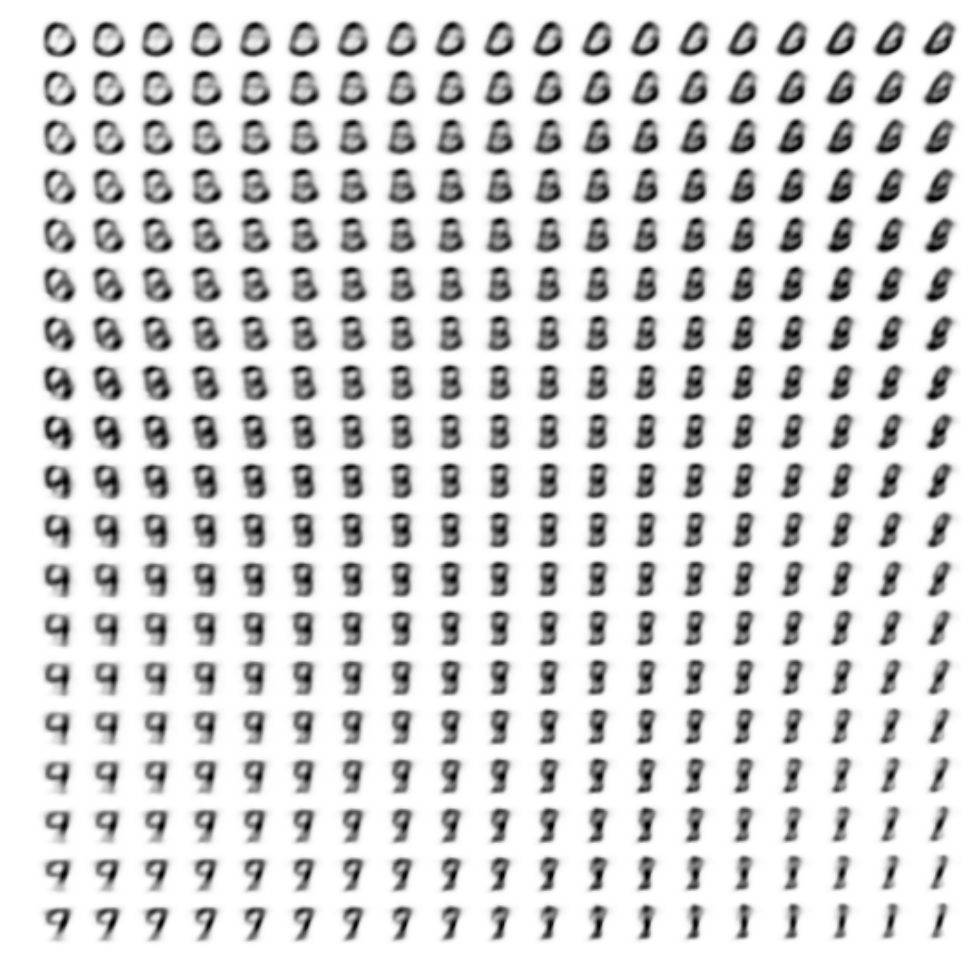

In [6]:
from scipy.stats import norm
import matplotlib.gridspec as gridspec

plt.figure(frameon=False, figsize = ( 12,12))

gs1 = gridspec.GridSpec(19, 19)
gs1.update(wspace=0.0, hspace=0.0) # set the spacing between axes. 

count = 0

for i in np.arange(0.05,1.,0.05):
    for j in np.arange(0.05,1.,0.05):
        plt.subplot(gs1[count])
        lat = np.array([norm.ppf(i),norm.ppf(j)])
        #lat = lat.reshape(lat.shape[0],1) 
        shared_lat = theano.shared(np.asarray(lat,dtype=theano.config.floatX),borrow=True)
        reco = np.reshape(sample_dat(lat),[28,28])
        plt.imshow(reco)
        plt.set_cmap('Greys')
        plt.axis('off')
        count += 1